# Instrumental Variables

Prof. Daniel de Abreu Pereira Uhr

### Conteúdo

1. Introdução ao Método de Variáveis Instrumentais
2. Regressão Linear Simples
3. Ampliando o Modelo de Regressão Linear
4. Endogeneidade
5. Primeio Estágio
6. Segundo Estágio
7. Álgebra Matricial
 


### Referências




### 1. Introdução ao Método de Variáveis Instrumentais


O método de variáveis instrumentais (*Instrumental Variables - IV*) é uma técnica estatística utilizada para lidar com problemas de endogeneidade em modelos de regressão. A endogeneidade ocorre quando uma variável explicativa está correlacionada com o erro do modelo, o que pode levar a estimativas viesadas e inconsistentes dos parâmetros do modelo.

### 2. Regressão Linear Simples



Em Acemoglu, Johnson, Robinson (2002), “ As origens coloniais do desenvolvimento comparativo ” , os autores desejam determinar se as diferenças nas instituições podem ou não ajudar a explicar os resultados econômicos observados.

Como medimos diferenças institucionais e resultados econômicos ?

Nesse artigo,

os resultados econômicos são representados pelo logaritmo do PIB per capita em 1995, ajustado pelas taxas de câmbio.
as diferenças institucionais são representadas por um índice de proteção contra a expropriação em média ao longo de 1985-95, construído pelo Political Risk Services Group .
Essas variáveis ​​e outros dados usados ​​no artigo estão disponíveis para download na página de Daron Acemoglu .

O conjunto de dados original está no .dtaformato Stata, mas foi convertido para .csv.

Primeiro, vamos carregar os dados e analisá-los.

In [3]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm

from numpy.linalg import inv
from statsmodels.iolib.summary2 import summary_col
from linearmodels.iv import IV2SLS

***Ajuste nos gráficos***

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d

%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid') 
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.figsize'] = (8,4)
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [ ]:
# Dados - Acemoglu Johnson Robinson
df = pd.read_csv('https://github.com/Daniel-Uhr/data/raw/main/AJR02.csv', index_col=0)
df

,GDP,Exprop,Mort,Latitude,Neo,Africa,Asia,Namer,Samer,logMort,Latitude2
1,8.39,6.50,78.20,0.3111,0,1,0,0,0,4.359270,0.096783
2,7.77,5.36,280.00,0.1367,0,1,0,0,0,5.634790,0.018687
3,9.13,6.39,68.90,0.3778,0,0,0,0,1,4.232656,0.142733
4,9.90,9.32,8.55,0.3000,1,0,0,0,0,2.145931,0.090000
5,9.29,7.50,85.00,0.2683,0,0,0,1,0,4.442651,0.071985
...,...,...,...,...,...,...,...,...,...,...,...
60,9.03,7.00,71.00,0.3667,0,0,0,0,1,4.262680,0.134469
61,10.22,10.00,15.00,0.4222,1,0,0,1,0,2.708050,0.178253
62,9.07,7.14,78.10,0.0889,0,0,0,0,1,4.357990,0.007903
63,7.28,6.41,140.00,0.1778,0,0,1,0,0,4.941642,0.031613


Vamos usar um gráfico de dispersão para ver se existe alguma relação óbvia entre o PIB per capita (GDP) e a proteção contra a expropriação.

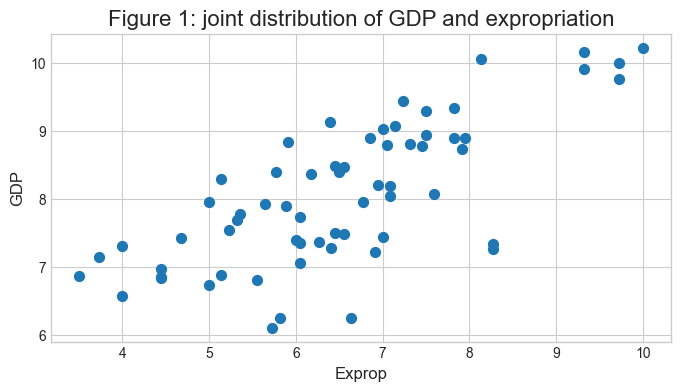

In [6]:
# Plotar relacionamento entre GDP e taxa de expropriação
fig, ax = plt.subplots(1,1)
ax.set_title('Figure 1: joint distribution of GDP and expropriation')
df.plot(x='Exprop', y='GDP', kind='scatter', s=50, ax=ax);

O gráfico mostra uma relação positiva bastante forte entre a proteção contra a expropriação e o logaritmo do PIB per capita.

Especificamente, se maior proteção contra expropriação é uma medida de qualidade institucional, então melhores instituições parecem estar positivamente correlacionadas com melhores resultados econômicos (maior PIB per capita).

Dado o enredo, escolher um modelo linear para descrever essa relação parece uma suposição razoável.

Podemos escrever nosso modelo como:

$$ GDP_{i} = \beta_0 + \beta_1 Exprop_i + u_i $$

onde:
* $GDP_{i}$ é o logaritmo do PIB per capita do país $i$ em 1995
* $\beta_0$ é o intercepto do modelo
* $\beta_1$ é a inclinação da linha de regressão, representando o efeito marginal da proteção contra a expropriação no PIB per capita
* $u_i$ é o erro do modelo, que captura a variação no PIB per capita que não pode ser explicada pela proteção contra a expropriação.

A técnica mais comum para estimar os parâmetros ($\beta$'s) do modelo linear é Mínimos Quadrados Ordinários (MQO).

Como o nome indica, um modelo OLS/MQO é resolvido encontrando os parâmetros que minimizam a soma dos resíduos quadrados , ou seja:

$$ \hat{\beta} = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} (\hat{u}_i)^2 = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} (GDP_i - \hat{GDP}_i)^2 $$

Lembre que para estimar a constante devemos adicionar uma coluna de 1s à matriz de variáveis independentes.

Agora, podemos construir nosso modelo `statsmodels` usando a função OLS.

In [16]:
# Regressão GDP sobre Expropriation Rate
reg1 = sm.OLS.from_formula('GDP ~ Exprop', df)
type(reg1)

statsmodels.regression.linear_model.OLS

Precisamos usar `.fit()` para obter estimativas de parâmetros

In [ ]:
results = reg1.fit()
type(results)

statsmodels.regression.linear_model.RegressionResultsWrapper

Agora temos o modelo de regressão ajustado armazenado em results.

Para visualizar os resultados da regressão MCO, podemos chamar o .summary() método .

Observe que uma observação foi erroneamente excluída dos resultados do artigo original (veja a nota localizada em maketable2.do da página de Acemoglu) e, portanto, os coeficientes diferem

In [9]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GDP   R-squared:                       0.540
Model:                            OLS   Adj. R-squared:                  0.532
Method:                 Least Squares   F-statistic:                     72.71
Date:                seg, 05 mai 2025   Prob (F-statistic):           4.84e-12
Time:                        16:44:02   Log-Likelihood:                -68.214
No. Observations:                  64   AIC:                             140.4
Df Residuals:                      62   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.6609      0.409     11.402      0.000       3.844       5.478
Exprop         0.5220      0.061      8.527      0.000       0.400       0.644
==============================================================================
Omnibus:                        7.134   Durbin-Watson:                   2.081
Prob(Omnibus):                  0.028   Jarque-Bera (JB):                6.698
Skew:                          -0.784   Prob(JB):                       0.0351
Kurtosis:                       3.234   Cond. No.                         31.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Observe que uma observação foi erroneamente excluída dos resultados do artigo original (veja a nota localizada em maketable2.do da página de Acemoglu) e, portanto, os coeficientes diferem ligeiramente.

Usando nossas estimativas de parâmetros, agora podemos escrever nossa relação estimada como:

$$ \hat{GDP}_{i} = 4.63 + 0.53 Exprop_i $$

Esta equação descreve a linha que melhor se ajusta aos nossos dados, conforme mostrado na Figura 2.

Podemos usar essa equação para prever o nível do logaritmo do PIB per capita para um valor do índice de proteção contra expropriação.

In [10]:
mean_expr = np.mean(df['Exprop'])
mean_expr

6.5160937500000005

In [11]:
predicted_logpdp95 = results.params[0] + results.params[1] * mean_expr
predicted_logpdp95

8.062499999999995

Ou seja, para um país com um valor de índice de **6,51** (a média do conjunto de dados), descobrimos que seu nível previsto de logaritmo do PIB per capita em 1995 é **8,09**.

Uma maneira mais fácil (e precisa) de obter esse resultado é usar `.predict()` e definir 
e

In [28]:
mean_expr = df['Exprop'].mean()
new_data = pd.DataFrame({'Exprop': [mean_expr]})
results.predict(new_data)

0    8.0625
dtype: float64

Podemos obter uma matriz de previsões $GDP_{i}$ para cada valor de $Exprop_i$ em nosso conjunto de dados, recorrendo `.predict()` aos nossos resultados.

Traçando os valores previstos em relação $Exprop_i$, mostra que os valores previstos estão ao longo da linha linear que ajustamos acima.

Os valores observados de $GDP_{i}$ também são plotados para fins de comparação.

In [29]:
# Make first new figure
def make_new_fig_2():

    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('Figure 2: OLS predicted values')

    # Drop missing observations from whole sample
    df_plot = df.dropna(subset=['GDP', 'Exprop'])
    sns.regplot(x=df_plot['Exprop'], y=df_plot['GDP'], ax=ax, order=1, ci=None, line_kws={'color':'r'})

    ax.legend(['observed', 'predicted'])
    ax.set_xlabel('Exprop')
    ax.set_ylabel('GDP')
    plt.show()

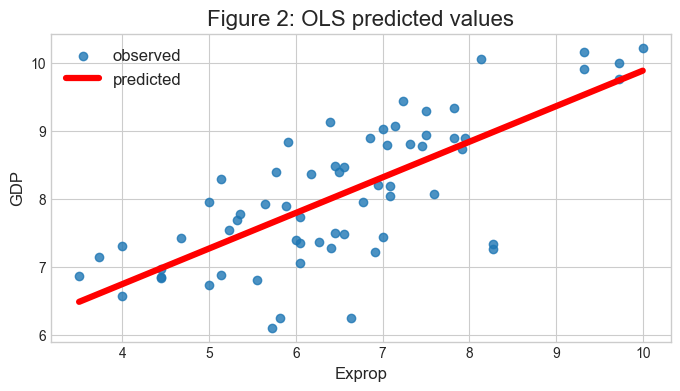

In [30]:
make_new_fig_2()

### 3. Ampliando o Modelo de Regressão Linear

Até agora, contabilizamos apenas as instituições que afetam o desempenho econômico. É quase certo que há vários outros fatores que afetam o PIB e que não estão incluídos em nosso modelo.

Deixando de fora as variáveis ​​que afetam $GDP_{i}$ resultará em **viés de variável omitida**, produzindo estimativas de parâmetros tendenciosas e inconsistentes.

Podemos estender nosso modelo de regressão bivariada para um modelo de regressão multivariada adicionando outros fatores que podem afetar $GDP_{i}$.

[AJR01] considere outros fatores como:

* o efeito do clima nos resultados económicos; a latitude é usada como proxy para isso
* diferenças que afetam tanto o desempenho econômico quanto as instituições, por exemplo, culturais, históricas, etc.; controladas com o uso de modelos continentais

Vamos estimar alguns dos modelos estendidos considerados no artigo (Tabela 2) usando dados de `maketable2.dta`

In [31]:
# Adicionar constante
df['const'] = 1

# Create lists of variables to be used in each regression
X1 = df[['const', 'Exprop']]
X2 = df[['const', 'Exprop', 'Latitude', 'Latitude2']]
X3 = df[['const', 'Exprop', 'Latitude', 'Latitude2', 'Asia', 'Africa', 'Namer', 'Samer']]

# Estimate an OLS regression for each set of variables
reg1 = sm.OLS(df['GDP'], X1, missing='drop').fit()
reg2 = sm.OLS(df['GDP'], X2, missing='drop').fit()
reg3 = sm.OLS(df['GDP'], X3, missing='drop').fit()

Agora que ajustamos nosso modelo, usaremos `summary_col` para exibir os resultados em uma única tabela (os números do modelo correspondem aos do artigo)

In [32]:
info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[reg1,reg2,reg3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1','Model 2','Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const','Exprop','Latitude','Latitude2'])

results_table

,Model 1,Model 2,Model 3
const,4.66***,4.55***,5.95***
,(0.41),(0.45),(0.68)
Exprop,0.52***,0.49***,0.40***
,(0.06),(0.07),(0.06)
Latitude,,2.16,0.42
,,(1.68),(1.47)
Latitude2,,-2.12,0.44
,,(2.86),(2.48)
Africa,,,-1.06**
,,,(0.41)


### 4. Endogeneidade

Conforme discutido por [AJR01], os modelos OLS/MQO provavelmente sofrem de **problemas de endogeneidade**, resultando em estimativas de modelo tendenciosas e inconsistentes.

Ou seja, é provável que exista uma relação bidirecional entre instituições e resultados econômicos:

* países mais ricos podem ter condições de pagar ou preferir instituições melhores
* variáveis ​​que afetam a renda também podem estar correlacionadas com diferenças institucionais
* a construção do índice pode ser tendenciosa; os analistas podem ser tendenciosos no sentido de ver os países com rendimentos mais elevados como tendo melhores instituições


Para lidar com a endogeneidade, podemos usar a ***regressão de mínimos quadrados em dois estágios (2SLS)***, que é uma extensão da regressão OLS.

Este método requer a substituição da variável endógena
com uma variável que é:

1. correlacionado com $Exprop_i$ 
2. não correlacionado com o termo de erro (ou seja, não deve afetar diretamente a variável dependente, caso contrário, estaria correlacionado com $u_i$ devido ao viés da variável omitida).
   

Podemos escrever nosso modelo como:

$$ GDP_{i} = \beta_0 + \beta_1 Exprop_i + u_i $$

$$ Exprop_i = \pi_0 + \pi_1 logMort_{i} + v_i $$



O novo conjunto de regressores logMorté chamado de instrumento , que visa remover a endogeneidade em nosso proxy de diferenças institucionais.

A principal contribuição de [AJR01] é o uso de taxas de mortalidade de colonos para instrumentar diferenças institucionais.

Eles levantam a hipótese de que taxas mais altas de mortalidade dos colonizadores levaram ao estabelecimento de instituições de natureza mais extrativista (menos proteção contra a expropriação), e essas instituições persistem até hoje.

Usando um gráfico de dispersão (Figura 3 em [AJR01] ), podemos ver que a proteção contra a expropriação está negativamente correlacionada com as taxas de mortalidade dos colonos, coincidindo com a hipótese dos autores e satisfazendo a primeira condição de um instrumento válido.




In [33]:
# Dropping NA's is required to use numpy's polyfit
df2 = df.dropna(subset=['logMort', 'Exprop'])
X = df2['logMort']
y = df2['Exprop']

In [34]:
# Make new figure 2
def make_new_figure_2():

    # Init figure
    fig, ax = plt.subplots(1,1)
    ax.set_title('Figure 3: First-stage')

    # Fit a linear trend line
    sns.regplot(x=X, y=y, ax=ax, order=1, scatter=True, ci=None, line_kws={"color": "r"})

    ax.set_xlim([1.8,8.4])
    ax.set_ylim([3.3,10.4])
    ax.set_xlabel('Log of Settler Mortality')
    ax.set_ylabel('Average Expropriation Risk 1985-95');

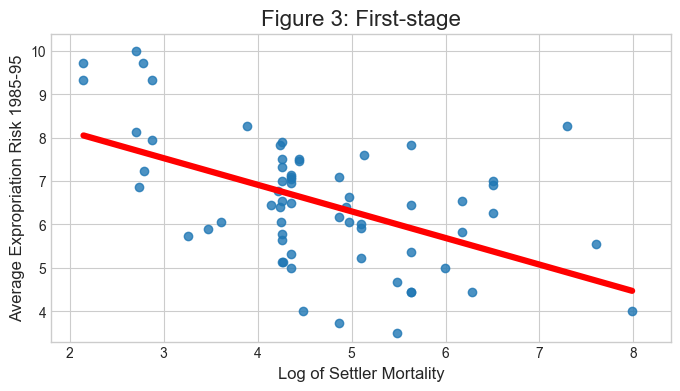

In [35]:
make_new_figure_2()

A segunda condição pode não ser satisfeita se as taxas de mortalidade dos colonos nos séculos XVII a XIX tiverem um efeito direto no PIB atual (além de seu efeito indireto por meio de instituições).

Por exemplo, as taxas de mortalidade de colonos podem estar relacionadas ao ambiente atual de doenças em um país, o que pode afetar o desempenho econômico atual.

[AJR01] argumentam que isso é improvável porque:

A maioria das mortes de colonos foi causada por malária e febre amarela e teve efeito limitado sobre a população local.
A carga de doenças sobre populações locais na África ou na Índia, por exemplo, não pareceu ser maior que a média, apoiada por densidades populacionais relativamente altas nessas áreas antes da colonização.

Como parecemos ter um instrumento válido, podemos usar a regressão 2SLS para obter estimativas de parâmetros consistentes e imparciais.


### 5. Primeio Estágio


A primeira etapa envolve a regressão da variável endógena ($Exprop_i$) no instrumento.

O instrumento é o conjunto de todas as variáveis ​​exógenas em nosso modelo (e não apenas a variável que substituímos).

Usando o modelo 1 como exemplo, nosso instrumento é simplesmente uma constante e taxas de mortalidade de colonos $logMort_i$.

Portanto, estimaremos a regressão do primeiro estágio como

$$ Exprop_i = \pi_0 + \pi_1 logMort_{i} + v_i $$





In [36]:
# Add a constant variable
df['const'] = 1

# Fit the first stage regression and print summary
results_fs = sm.OLS(df['Exprop'],
                    df.loc[:,['const', 'logMort']],
                    missing='drop').fit()
results_fs.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Exprop   R-squared:                       0.274
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     23.34
Date:                seg, 05 mai 2025   Prob (F-statistic):           9.27e-06
Time:                        17:52:13   Log-Likelihood:                -104.69
No. Observations:                  64   AIC:                             213.4
Df Residuals:                      62   BIC:                             217.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.3659      0.611     15.339      0.000       8.145      10.586
logMort       -0.6133      0.127     -4.831      0.000      -0.867      -0.360
==============================================================================
Omnibus:                        0.047   Durbin-Watson:                   1.592
Prob(Omnibus):                  0.977   Jarque-Bera (JB):                0.154
Skew:                           0.060   Prob(JB):                        0.926
Kurtosis:                       2.792   Cond. No.                         19.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Precisamos recuperar os valores previstos de
usando `.predict()`.

Substituímos então a variável endógena $Exprop_i$ com os valores previstos $\hat{Exprop}_i$ no modelo linear original.

Nossa regressão de segundo estágio é assim:

$$ GDP_{i} = \beta_0 + \beta_1 \hat{Exprop}_i + u_i $$



### 6. Segundo Estágio


In [37]:
# Second stage
df['predicted_Exprop'] = results_fs.predict()
results_ss = sm.OLS.from_formula('GDP ~ predicted_Exprop', df).fit()

# Print
results_ss.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    GDP   R-squared:                       0.462
Model:                            OLS   Adj. R-squared:                  0.453
Method:                 Least Squares   F-statistic:                     53.24
Date:                seg, 05 mai 2025   Prob (F-statistic):           6.58e-10
Time:                        17:53:15   Log-Likelihood:                -73.208
No. Observations:                  64   AIC:                             150.4
Df Residuals:                      62   BIC:                             154.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            2.0448      0.830      2.463      0.017       0.385       3.705
predicted_Exprop     0.9235      0.127      7.297      0.000       0.671       1.177
==============================================================================
Omnibus:                       10.463   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.693
Skew:                          -0.806   Prob(JB):                      0.00476
Kurtosis:                       4.188   Cond. No.                         57.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Os resultados da regressão do segundo estágio nos fornecem uma estimativa imparcial e consistente do efeito das instituições nos resultados econômicos.

O resultado sugere uma relação positiva mais forte do que os resultados do OLS indicaram.

Observe que, embora nossas estimativas de parâmetros estejam corretas, nossos erros padrão não estão e, por esse motivo, não é recomendado calcular 2SLS 'manualmente' (em etapas com OLS).

Podemos estimar corretamente uma regressão 2SLS em uma etapa usando o pacote `linearmodels` , uma extensão do `statsmodels`

Observe que ao usar IV2SLS, as variáveis ​​exógenas e de instrumento são divididas nos argumentos da função (enquanto antes o instrumento incluía variáveis ​​exógenas)

In [38]:
# IV regression
iv = IV2SLS(dependent=df['GDP'],
            exog=df['const'],
            endog=df['Exprop'],
            instruments=df['logMort']).fit()

# Print
iv.summary

<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:                    GDP   R-squared:                      0.2205
Estimator:                    IV-2SLS   Adj. R-squared:                 0.2079
No. Observations:                  64   F-statistic:                    29.811
Date:                seg, mai 05 2025   P-value (F-stat)                0.0000
Time:                        17:54:09   Distribution:                  chi2(1)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
==============================================================================
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
const          2.0448     1.1273     1.8139     0.0697     -0.1647      4.2542
Exprop         0.9235     0.1691     5.4599     0.0000      0.5920      1.2550
==============================================================================

Endogenous: Exprop
Instruments: logMort
Robust Covariance (Heteroskedastic)
Debiased: False
"""

Dado que agora temos estimativas consistentes e imparciais, podemos inferir do modelo que estimamos que as diferenças institucionais (decorrentes de instituições criadas durante a colonização) podem ajudar a explicar as diferenças nos níveis de renda entre os países atualmente.

[AJR01] usa um efeito marginal de 0,94 para calcular que a diferença no índice entre Chile e Nigéria (ou seja, qualidade institucional) implica uma diferença de até 7 vezes na renda, enfatizando a importância das instituições no desenvolvimento econômico.

### 7. Álgebra Matricial



O parâmetro $\beta$ OLS também pode ser estimado usando álgebra matricial e `numpy`.

A equação linear que queremos estimar é (escrita em forma de matriz)

$$ y = X \beta + u $$


In [39]:
# Init 
X = df[['const', 'Exprop']].values
Z = df[['const', 'logMort']].values
y = df['GDP'].values

Para resolver o parâmetro desconhecido $\beta$, queremos minimizar a soma dos resíduos quadrados

$$ \hat{\beta} = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} \hat{\epsilon}`\hat{\epsilon}$$


Reorganizando a primeira equação e substituindo na segunda equação, podemos escrever $\beta$ 

$$ \hat{\beta} = \underset{\beta}{\text{argmin}} \sum_{i=1}^{n} (y - X\beta)^{´}(y - X\beta) $$

A resolução deste problema de otimização fornece a solução para o $\beta$ OLS como:

$$ \hat{\beta} = (X^{´}X)^{-1}X^{´}y $$



In [40]:
# Compute beta OLS
beta_OLS = inv(X.T @ X) @ X.T @ y

print(beta_OLS)

[4.66087966 0.52203367]


Como vimos acima, o coeficiente MQO pode sofrer de viés de endogeneidade. Podemos resolver o problema instrumentando a taxa média de expropriação prevista com a mortalidade média dos colonos.

Se definirmos a mortalidade dos colonos como
, nosso modelo completo é

In [41]:
# Compute beta IV
beta_IV = inv(Z.T @ X) @ Z.T @ y

print(beta_IV)

[2.0447613  0.92351936]


In [31]:
# Estimate first stage coefficient
gamma_hat = (inv(Z.T @ Z) @ Z.T @ X)

print(gamma_hat[1,1])

-0.613289272386867


In [32]:
# Compute variance of the estimator
u = X - Z @ gamma_hat
var_gamma_hat = np.var(u) * inv(Z.T @ Z)

# Compute standard errors
std_gamma_hat = var_gamma_hat[1,1]**.5
print(std_gamma_hat)

0.08834733362858559


In [33]:
# Compute 95% confidence interval
CI = [gamma_hat[1,1] - 1.96*std_gamma_hat, gamma_hat[1,1] + 1.96*std_gamma_hat]

print(CI)

[-0.7864500462988948, -0.44012849847483926]


In [34]:
df['logMort_2'] = df['logMort']**2

In [35]:
# Define Z
Z1 = df[['const', 'logMort', 'logMort_2']].values

# Compute beta 2SLS in two steps
X_hat = Z1 @ inv(Z1.T @ Z1) @ Z1.T @ X
beta_2SLS = inv(X_hat.T @ X_hat) @ X_hat.T @ y

print(beta_2SLS)

[3.08817432 0.76339075]


In [36]:
# Compute beta 2SLS in one step
beta_2SLS = inv(X_hat.T @ Z1 @ inv(Z1.T @ Z1) @ Z1.T @ X_hat) @ X_hat.T @ Z1 @ inv(Z1.T @ Z1) @ Z1.T @ y
    
print(beta_2SLS)

[3.08817432 0.76339075]


# Introdução à Inteligência Artificial e Redes Neurais Artificiais (Deep Learning)




## O que é Inteligência Artificial?

Relembrando a estrutura geral


Vejamos as possíves subáreas da AI:

<div style="text-align:center;">
    <img src="images\IA_ML_DL.png"  alt="Imagem" style="width: 450px;"/>
</div>

Assim, temos que:
* AI: Campo amplo da ciência da computação que busca criar sistemas capazes de simular comportamentos humanos inteligentes.
* ML: Subárea da AI que se concentra no desenvolvimento de algoritmos e modelos que permitem que os computadores aprendam a partir de dados.
* DL: Subárea do ML que se concentra no desenvolvimento de redes neurais profundas para tarefas de aprendizado de máquina.


A Inteligência Artificial (IA) é o campo da ciência da computação que se dedica a criar sistemas capazes de executar tarefas que normalmente requerem inteligência humana. Essas tarefas incluem:

- Reconhecimento de padrões em imagens, áudios e vídeos.
- Predição de eventos futuros com base em dados históricos.
- Processamento de linguagem natural para interagir com humanos de forma mais intuitiva.
- Otimização de sistemas complexos e tomada de decisão automatizada.

A IA depende fortemente de matemática, estatística e computação para extrair informações útis dos dados e transformar essas informações em ações automatizadas. Entre suas principais subáreas, destacam-se:

1. Aprendizado de Máquina (Machine Learning).
2. Aprendizado Profundo (Deep Learning).
3. Visão Computacional.
4. Processamento de Linguagem Natural.
5. Robótica e Sistemas Autônomos.

---

## Redes Neurais Artificiais: A Inspiração Biológica
As redes neurais artificiais (RNAs) são modelos computacionais inspirados no funcionamento do cérebro humano. Elas são compostas por "neurônios artificiais", que são abstrações matemáticas baseadas nos neurônios biológicos. A estrutura básica de uma RNA é baseada em:

1. **Dendritos**: recebem informações (entradas).
2. **Núcleo Somático**: integra as informações recebidas e produz uma síntese.
3. **Axônios**: transmitem a saída para outros neurônios.



<div style="text-align:center;">
    <img src="images\neuronio_biologico.png"  alt="Imagem" style="width: 450px;"/>
</div>



### Funcionamento do Neurônio Biológico

O neurônio biológico processa informações através de sinais elétricos e químicos. Dendritos recebem sinais de outros neurônios, que são somados no núcleo somático. Se o sinal agregado ultrapassar um determinado limiar, um novo sinal é gerado e transmitido pelo axônio aos próximos neurônios. Este funcionamento pode ser modelado matematicamente para criar algoritmos de aprendizado.

### Analogias no Neurônio Artificial

O neurônio artificial replica esse processo de forma matemática:

- **Entradas (inputs)**: Representam os dendritos, recebendo dados de entrada.
- **Função Somatória**: Soma ponderada das entradas, representando o núcleo somático.
- **Função de Ativação**: Determina a saída do neurônio, simulando a transmissão pelo axônio.

Abaixo, uma tabela comparativa:

| **Neurônio Biológico** | **Neurônio Artificial** |
|--------------------------|---------------------------|
| Dendritos                | Entradas (Vetores ou Matrizes) |
| Núcleo Somático          | Função Somatória         |
| Axônio                   | Saídas (Ativadas por Função) |

---

# Fundamentos Matemáticos das Redes Neurais Artificiais

As redes neurais dependem de conceitos matemáticos fundamentais para processar informações e aprender padrões complexos. Esses conceitos incluem vetores, matrizes e tensores, que formam a base do cálculo em IA.

## Vetores

Um vetor é uma representação unidimensional de dados. Em IA, eles podem representar entradas, pesos ou saídas de um modelo.

### Representação Matemática
Um vetor $ \mathbf{x} $ com $ n $ elementos pode ser escrito como:
$$
\mathbf{x} = \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}
$$

#### Operações Fundamentais
1. **Produto Escalar**:
   $$
   \mathbf{a}^T \mathbf{b} = \sum_{i=1}^n a_i b_i
   $$

2. **Norma do Vetor** (magnitude):
   $$
   \|\mathbf{x}\| = \sqrt{\sum_{i=1}^n x_i^2}
   $$


<div style="text-align:center;">
    <img src="images\neuronio_artificial.png"  alt="Imagem" style="width: 450px;"/>
</div>


### Exemplos Práticos
1. Representar pixels de uma imagem em escala de cinza como um vetor.
2. Representar variáveis de entrada em um modelo preditivo.

## Matrizes

As matrizes permitem trabalhar com dados bidimensionais, como coleções de vetores.

### Representação Matemática
Uma matriz $ \mathbf{X} $ com $ m $ linhas e $ n $ colunas pode ser representada como:
$$
\mathbf{X} = \begin{bmatrix} x_{11} & x_{12} & \dots & x_{1n} \\ x_{21} & x_{22} & \dots & x_{2n} \\ \vdots & \vdots & \ddots & \vdots \\ x_{m1} & x_{m2} & \dots & x_{mn} \end{bmatrix}
$$

#### Operações Fundamentais
1. **Multiplicação Matricial**:
   $$
   \mathbf{C} = \mathbf{A} \cdot \mathbf{B}
   $$

2. **Transposição**:
   $$
   \mathbf{A}^T = \begin{bmatrix} a_{11} & a_{21} \\ a_{12} & a_{22} \end{bmatrix}
   $$

### Exemplos Práticos
1. Representar uma coleção de imagens como uma matriz onde cada linha é uma imagem vetorizada.
2. Representar pesos conectando camadas em redes neurais.

## Tensores

Os tensores generalizam vetores e matrizes para dimensões superiores, sendo essenciais para modelar dados complexos em IA.

### Representação Matemática
Um tensor de ordem 3 pode ser representado como um conjunto de matrizes:
$$
\mathcal{T} = \begin{bmatrix} \mathbf{A}_1 \\ \mathbf{A}_2 \\ \vdots \\ \mathbf{A}_k \end{bmatrix}
$$

### Exemplos Práticos
1. Imagens RGB são representadas como tensores de ordem 3: Altura, Largura e Canais de Cor.
2. Representação de sequências temporais multimodais.

---

# O Processamento de Informações em Redes Neurais

## Fluxo de Informação

1. **Multiplicação Entrada-Peso**:
   $$
   \mathbf{z} = \mathbf{W}^T \mathbf{x}
   $$

2. **Soma (Função Somatória)**:
   $$
   z = \sum_{i=1}^n w_i x_i + b
   $$

3. **Função de Ativação**:
   $$
   f(z) = \frac{1}{1 + e^{-z}}
   $$

4. **Saída**:
   Os valores calculados são propagados para a próxima camada.

## Backpropagation e Aprendizado

O processo de aprendizado ajusta os pesos para minimizar o erro. Este ajuste é feito através de:

1. **Função de Custo**:
   $$
   J(\mathbf{W}) = \frac{1}{m} \sum_{i=1}^m (\hat{y}_i - y_i)^2
   $$

2. **Descida de Gradiente**:
   $$
   \mathbf{W} = \mathbf{W} - \eta \nabla J(\mathbf{W})
   $$

---

# Interseção entre IA e Matemática Avançada

## Álgebra Linear na Inteligência Artificial

A IA utiliza intensamente conceitos de álgebra linear, como:
- Multiplicações matriciais para modelar relações complexas.
- Decomposição de tensores para otimizar representações de dados.

## Modelos de Altíssima Dimensão

Em modelos modernos, tensores podem ter milhares ou até milhões de dimensões, representando dados de alta complexidade. Exemplos:

- **Redes Convolucionais (CNNs)**: Representam imagens como tensores 4D.
- **Transformers**: Utilizam tensores para processar linguagens naturais.

---

# Conclusão e Reflexões

A combinação de inspiração biológica e matemática avançada torna a IA uma ferramenta poderosa para resolver problemas reais. No entanto, é essencial compreender seus fundamentos para avançar no campo.

## Recomendações de Estudos Adicionais

1. **Matemática Avançada**:
   - Álgebra Linear.
   - Otimização Convexa.

2. **Implementação Prática**:
   - Estudo de frameworks como TensorFlow e PyTorch.
   - Análise de casos práticos em Python.

3. **Referências Clássicas**:
   - "Deep Learning" por Ian Goodfellow et al.
   - "Hands-On Machine Learning" por Aurélien Géron.
